# Predicting Next-Day Stock Price Direction in the S&P 500

In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

from xgboost import XGBClassifier

DATA_PATH = "https://raw.githubusercontent.com/tabbott207/3156Final/refs/heads/main/data/all_stocks_5yr.csv"

RANDOM_STATE = 42

plt.style.use("seaborn-v0_8")

In [23]:
# Load the CSV
df = pd.read_csv(DATA_PATH)

print("Columns:", df.columns.tolist())
print("Number of rows:", len(df))

# Convert date to datetime and sort
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["Name", "date"]).reset_index(drop=True)

df.head()

Columns: ['date', 'open', 'high', 'low', 'close', 'volume', 'Name']
Number of rows: 619040


,date,open,high,low,close,volume,Name
0,2013-02-08,45.07,45.35,45.00,45.08,1824755,A
1,2013-02-11,45.17,45.18,44.45,44.60,2915405,A
2,2013-02-12,44.81,44.95,44.50,44.62,2373731,A
3,2013-02-13,44.81,45.24,44.68,44.75,2052338,A
4,2013-02-14,44.72,44.78,44.36,44.58,3826245,A


In [24]:
print("Date range:", df["date"].min(), "to", df["date"].max())
print("\nSample of tickers:", df["Name"].unique()[:10])

print("\nSummary of closing prices:")
print(df["close"].describe())

print("\nSummary of volume:")
print(df["volume"].describe())

Date range: 2013-02-08 00:00:00 to 2018-02-07 00:00:00

Sample of tickers: ['A' 'AAL' 'AAP' 'AAPL' 'ABBV' 'ABC' 'ABT' 'ACN' 'ADBE' 'ADI']

Summary of closing prices:
count    619040.000000
mean         83.043763
std          97.389748
min           1.590000
25%          40.245000
50%          62.620000
75%          94.410000
max        2049.000000
Name: close, dtype: float64

Summary of volume:
count    6.190400e+05
mean     4.321823e+06
std      8.693610e+06
min      0.000000e+00
25%      1.070320e+06
50%      2.082094e+06
75%      4.284509e+06
max      6.182376e+08
Name: volume, dtype: float64


Sample ticker: A


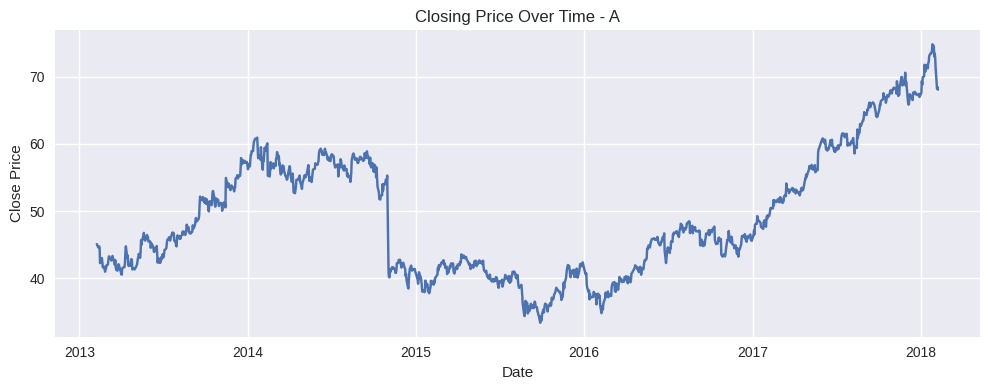

In [25]:
sample_ticker = df["Name"].unique()[0]
print("Sample ticker:", sample_ticker)

sample_df = df[df["Name"] == sample_ticker]

plt.figure(figsize=(10, 4))
plt.plot(sample_df["date"], sample_df["close"])
plt.title(f"Closing Price Over Time - {sample_ticker}")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.tight_layout()
plt.show()

count    618535.000000
mean          0.000541
std           0.016060
min          -0.626183
25%          -0.006793
50%           0.000635
75%           0.008105
max           1.009513
Name: return_1d, dtype: float64


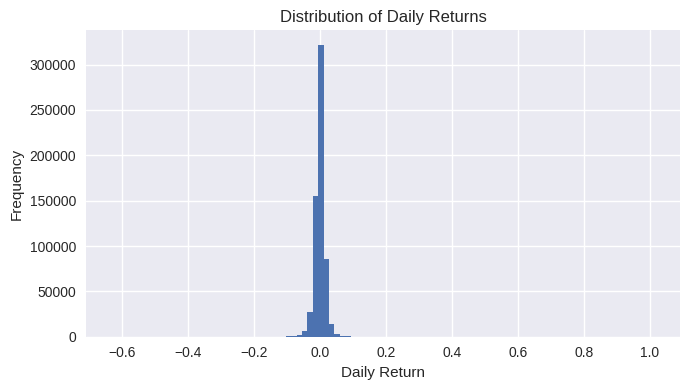

In [26]:
df["close_prev"] = df.groupby("Name")["close"].shift(1)
df["return_1d"] = (df["close"] - df["close_prev"]) / df["close_prev"]

print(df["return_1d"].describe())

plt.figure(figsize=(7, 4))
df["return_1d"].hist(bins=100)
plt.title("Distribution of Daily Returns")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()